In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sympy import Symbol
import centrex_TlF as centrex
import matplotlib.pyplot as plt

import sys
sys.path.append("../..")
from utils.plot_utils import set_fontsize

### Some initial setup of states and transitions to use

In [2]:
nprocs = 6

# Γ
Γ = 1.56e6*2*np.pi

# TlF temperature
T = 6.3

# Define all involved states

# ground state J levels
ground_Js = [0,2]

# excited state quantum numbers
excited_Js = [1]
excited_F1s = [3/2]
excited_Fs = [1]
excited_Ps = [-1]

# Settings for transitions

# min and max J level to look for mixing in the B state
excited_Jmin = 1
excited_Jmax = 2


# main laser transition P(2) F'=1 F1'=3/2

ground_main_approx = 1*centrex.CoupledBasisState(J=2,F1=3/2,F=2,mF=0,I1=1/2,I2=1/2,
                                                 electronic_state='X', P = (-1)**2, Omega = 0)
excited_main_approx = 1*centrex.CoupledBasisState(J=1,F1=3/2,F=1,mF=0,I1=1/2,I2=1/2, 
                                                  electronic_state='B', P = -1, Omega = 1)
# ground laser J
laser_J = [2]

transitions = [{'ground main approx': ground_main_approx, 
                'excited main approx': excited_main_approx,
                'ground states approx': 1*centrex.states.generate_coupled_states_ground(laser_J),
                'excited states approx': 1*centrex.states.generate_coupled_states_excited(
                                                excited_Js, excited_Fs, excited_F1s, excited_Ps),
                'main polarization': np.array([0,0,1]),
                'polarizations': [np.array([0,0,1]), np.array([1,0,0])],
                'polarization symbols': [Symbol("Plz"), Symbol("Plx")],
                'Ω symbol': Symbol('Ωl', complex = True),
                'Δ symbol': Symbol('δl'),
                'description': "laser transition"
               }]

### Specifying parameters and the ode function preamble
Allows for setting parameters to be time dependent (e.g. sin(t), cos(t))

In [17]:
# order of parameters in p
parameters = ['Ωl', 'δl', 'Plx', 'Plz']

In [18]:
preamble = """function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tΩl = p[1]
\t\tδl = p[2]
\t\tΩlᶜ = conj(Ωl)

\t\tPlx = p[3]
\t\tPlz = p[4]
"""

In [151]:
odepars = centrex.lindblad.odeParameters(parameters)
odepars.Ωl = Γ
odepars.Plz = 1
odepars

odeParameters(Ωl: 9.80e+06, δl: 0.00e+00, Plx: 0.00e+00, Plz: 1.00e+00)

## Start calculations for Hamiltonian and transitions

In [9]:
%%time 
ground_states_approx = centrex.states.generate_coupled_states_ground(ground_Js)
excited_states_approx = centrex.states.generate_coupled_states_excited(excited_Js, excited_Fs, 
                                                                       excited_F1s, excited_Ps)

ground_states, excited_states, QN, H_int, V_ref_int = centrex.hamiltonian.generate_total_reduced_hamiltonian(
                                            ground_states_approx, excited_states_approx)

Wall time: 6.53 s


In [10]:
%%time
couplings = []
for transition in transitions:
    coupling = centrex.couplings.generate_coupling_field(
                                        transition['ground main approx'],
                                        transition['excited main approx'],
                                        transition['ground states approx'],
                                        transition['excited states approx'],
                                        H_int, QN, V_ref_int, 
                                        pol_main = transition['main polarization'],
                                        pol_vec = transition['polarizations'],
                                        nprocs = nprocs)
    couplings.append(coupling)

Wall time: 12.9 s


In [11]:
%%time
H_symbolic = centrex.lindblad.generate_total_symbolic_hamiltonian(QN, H_int, couplings, transitions)

Wall time: 177 ms


In [12]:
%%time
C_array = centrex.couplings.collapse_matrices(QN, ground_states, excited_states, gamma = Γ)
system = centrex.lindblad.generate_system_of_equations_symbolic(H_symbolic, C_array, progress = False, fast = True)

Wall time: 6.26 s


In [13]:
%%time
# convert matrix to system of equations code
code_lines = centrex.lindblad.system_of_equations_to_lines(system, nprocs = nprocs)

Wall time: 8.6 s


# Solving ODE system with Julia
Need to install Julia and add the following packages to Julia:  
* [DifferentialEquations](https://diffeq.sciml.ai/stable/)
* [Trapz](https://github.com/francescoalemanno/Trapz.jl)

And install [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) for python.  

In [15]:
# import julia
# julia.install()

In [16]:
from julia import Main
centrex.lindblad.initialize_julia(nprocs = nprocs)

_ = centrex.lindblad.generate_ode_fun_julia(preamble, code_lines)

# generate initial conditions
ρ_ini = centrex.utils.generate_thermal_J(ground_Js, len(excited_states), T, normalized = True)
centrex.lindblad.setup_variables_julia(Γ, ρ_ini)
odepars.generate_p_julia()

Initialized Julia with 6 processes


### Setting up the ODE problem to solve
`tmp = 0` is just to prevent `Main.eval` from outputting the problem in the notebook.  
The ODEProblem takes a function to solve (`Lindblad_rhs!` in this case), initial conditions `ρ_ini`, a timespan `tspan` an additional arguments for the ODE function, denoted here by `p` 

In [30]:
Main.eval("""
tspan = (0.0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ,tspan,p)
""");

In [36]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 1e-9, reltol = 1e-6, progress = false);
tmp = 0
""");

Wall time: 335 ms


0

In [37]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol.t")

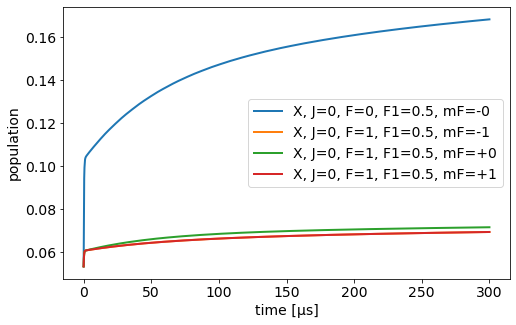

In [38]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ls = '-'
    if idx in [0,1,2,3]:
        s = QN[idx].find_largest_component()
        label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
        ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
#         ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

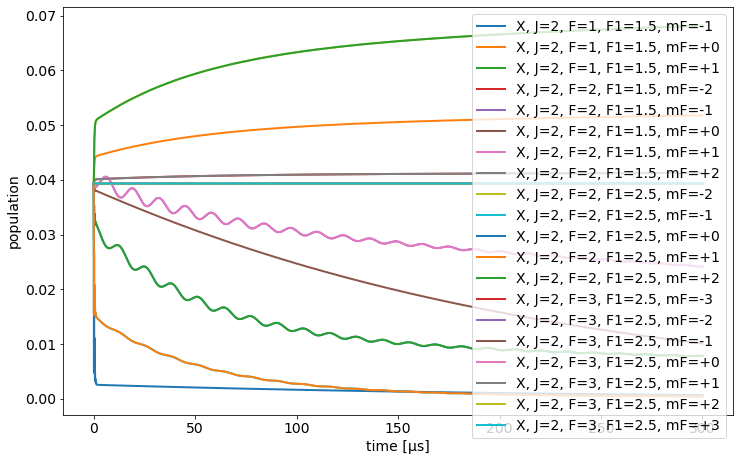

In [39]:
fig, ax = plt.subplots(figsize = (12,7.5))

for idx, pop in enumerate(pop_results):
    ls = '-'
    if idx in range(4,24):
        s = QN[idx].find_largest_component()
        label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
        ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
#         ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [40]:
p = pop_results[-10:-3].sum(axis = 0)
print(f'accumulation J=2 F=3 : {p[-1]/p[0]:.2f}')

accumulation J=2 F=3 : 1.00


In [41]:
p = pop_results[[0]].sum(axis = 0)
print(f'accumulation J=0 F=0 : {p[-1]/p[0]:.2f}')

accumulation J=0 F=0 : 3.15


In [42]:
p = pop_results[1:4].sum(axis = 0)
print(f'accumulation J=0 F=1 : {p[-1]/p[0]:.2f}')

accumulation J=0 F=1 : 1.31


In [43]:
p = pop_results[:4].sum(axis = 0)
print(f'accumulation J=0: {p[-1]/p[0]:.2f}')

accumulation J=0: 1.77


In [44]:
p = pop_results[-23:-3].sum(axis = 0)
print(f'depletion J=2: {p[-1]/p[0]:.2f}')

depletion J=2: 0.79


In [45]:
np.diag(ρ_ini)[:4]

array([0.05334403+0.j, 0.05334403+0.j, 0.05334403+0.j, 0.05334403+0.j])

In [46]:
pop_results[:4,-1]

array([0.16810648, 0.0693516 , 0.07155185, 0.06935157])

In [47]:
ρ_rc = np.zeros(ρ_ini.shape, dtype = complex)
p = centrex.utils.thermal_population(2, T)
levels = centrex.utils.J_levels(2)
np.fill_diagonal(ρ_rc[4:24,4:24], p/levels)
ρ_rc /= np.diag(ρ_rc).sum()
Main.ρ_rc = ρ_rc

In [48]:
Main.eval("""
tspan = (0.0, 300e-6)
prob_rc = ODEProblem(Lindblad_rhs!,ρ_rc,tspan,p)
""");

In [49]:
%%time
Main.eval("""
@time sol_rc = solve(prob_rc, Tsit5(), abstol = 1e-9, reltol = 1e-6, progress = false);
tmp = 0
""");

Wall time: 629 ms


0

In [50]:
ut = np.array(Main.eval("sol_rc[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol_rc.t")

In [51]:
pop_results[:,-1][4:24]

array([0.00995647, 0.06582725, 0.0099593 , 0.05246312, 0.03067404,
       0.01284008, 0.03067152, 0.05246308, 0.0866561 , 0.00060412,
       0.0008633 , 0.00060406, 0.08665595, 0.05      , 0.05      ,
       0.05      , 0.05      , 0.05      , 0.05      , 0.05      ])

In [52]:
pop_results[:,-1][:4]

array([0.1458924 , 0.02034971, 0.02314679, 0.02034968])

## Scan Rabi Rate

In [97]:
Main.eval("""
tspan = (0.0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ,tspan,p)
""");

In [98]:
# generate the prob_func to remake the problem for each iteration
centrex.lindblad.setup_parameter_scan_1D(odepars, 'Ωl', np.linspace(0,Γ,201))

In [125]:
# generate the output_func to transform the ode slution after integration
centrex.lindblad.setup_ratio_calculation([2,3,4])

In [126]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [127]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 1e-9, reltol = 1e-6, save_everystep = false, dt=1e-12, adaptive = true)
sim.elapsedTime
""")

2.7196221

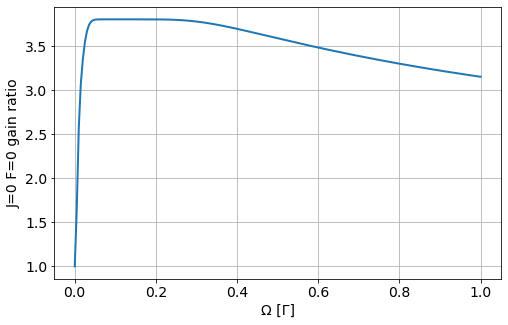

In [128]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Main.params/Main.Γ, Main.sim[0], lw = 2)
ax.grid(True)

ax.set_xlabel('Ω [Γ]')
ax.set_ylabel('J=0 F=0 gain ratio')
set_fontsize(ax, 14)

In [129]:
print(f"maximum gain {np.max(Main.sim[0]):.3f}")

maximum gain 3.803


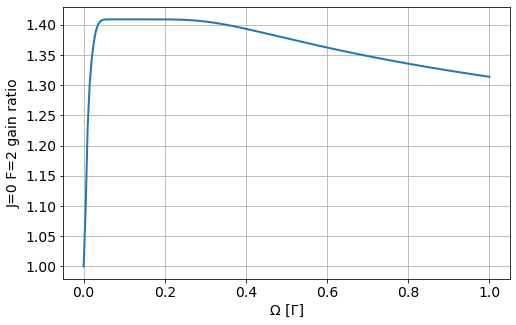

In [130]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Main.params/Main.Γ, Main.sim[1], lw = 2)
ax.grid(True)

ax.set_xlabel('Ω [Γ]')
ax.set_ylabel('J=0 F=2 gain ratio')
set_fontsize(ax, 14)

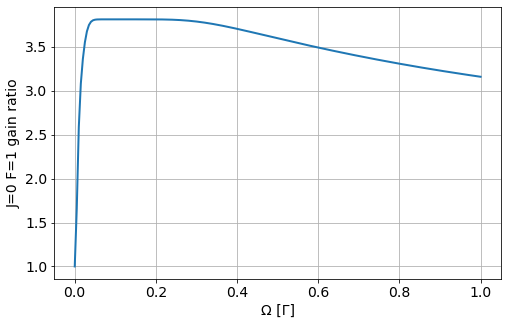

In [131]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Main.params/Main.Γ, 3*0.337/0.147*(np.asarray(Main.sim[1])-1) + 1, lw = 2)
ax.grid(True)

ax.set_xlabel('Ω [Γ]')
ax.set_ylabel('J=0 F=1 gain ratio')
set_fontsize(ax, 14)

### Changing Initial Temperature

In [140]:
ρ_scan = [] 
Ts = np.linspace(0.1,40,101)

for Ti in Ts:
    ρ = centrex.utils.generate_thermal_J(ground_Js, len(excited_states), Ti, normalized = True)
    ρ_scan.append(ρ)
    
centrex.lindblad.setup_initial_condition_scan(ρ_scan)

In [141]:
odepars.Ωl = 0.2*Γ
odepars.δl = 0
odepars.Plx = 0
odepars.Plz = 1
odepars.generate_p_julia()
Main.eval("""
tspan = (0.0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ,tspan,p)
""");

In [142]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [143]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 1e-9, reltol = 1e-6, save_everystep = false, dt = 1e-12, adaptive = true)
sim.elapsedTime
""")

5.9564931

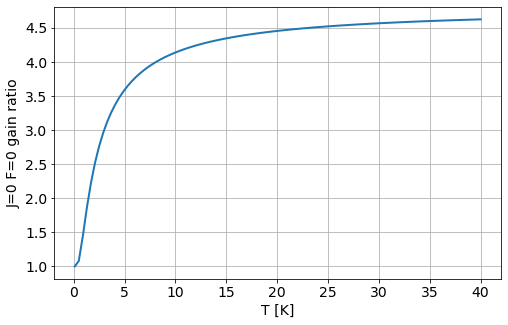

In [144]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Ts, Main.sim[0], lw = 2)
ax.grid(True)

ax.set_xlabel('T [K]')
ax.set_ylabel('J=0 F=0 gain ratio')
set_fontsize(ax, 14)

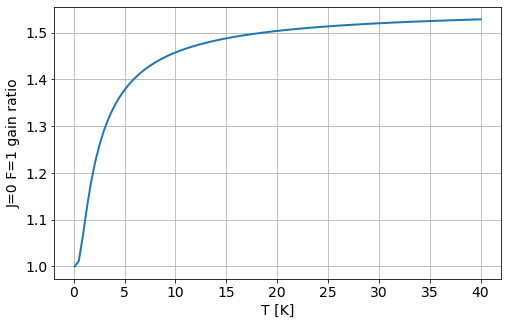

In [145]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Ts, Main.sim[1], lw = 2)
ax.grid(True)

ax.set_xlabel('T [K]')
ax.set_ylabel('J=0 F=1 gain ratio')
set_fontsize(ax, 14)

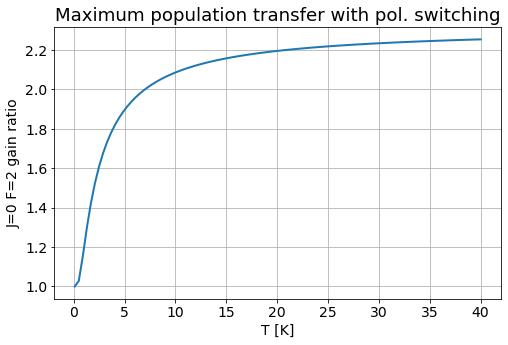

In [146]:
m_J0F1 = np.s_[1:4]
m_J2 = np.s_[4:24]

gains = []
for ρ in ρ_scan:
    F1_pop = np.diag(ρ)[m_J0F1].real.sum()
    J2_pop = np.diag(ρ)[m_J2].real.sum()
    J2_cooled = (13/20) * (0.147/(0.147+0.337)) * J2_pop
    gain = (F1_pop + J2_cooled) / F1_pop
    gains.append(gain)
    
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Ts, gains, lw = 2)
ax.grid(True)

ax.set_xlabel('T [K]')
ax.set_ylabel('J=0 F=2 gain ratio')
ax.set_title('Maximum population transfer with pol. switching', fontsize = 15)
set_fontsize(ax, 14)

In [149]:
n_couplings = len([val for val in np.nonzero(couplings[0]['fields'][0]['field'])[0] if val in range(4,20)])

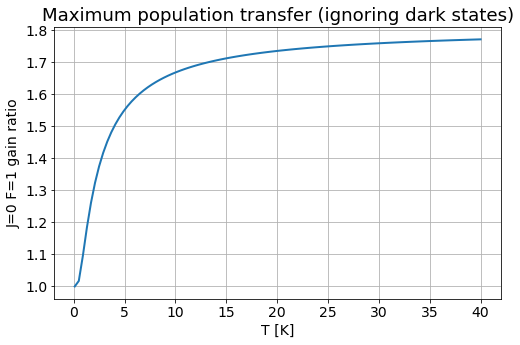

In [150]:
m_J0F1 = np.s_[1:4]
m_J2 = np.s_[4:24]

gains = []
for ρ in ρ_scan:
    F1_pop = np.diag(ρ)[m_J0F1].real.sum()
    J2_pop = np.diag(ρ)[m_J2].real.sum()
    J2_cooled = (n_couplings/20) * (0.147/(0.147+0.337)) * J2_pop
    gain = (F1_pop + J2_cooled) / F1_pop
    gains.append(gain)
    
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Ts, gains, lw = 2)
ax.grid(True)

ax.set_xlabel('T [K]')
ax.set_ylabel('J=0 F=1 gain ratio')
ax.set_title('Maximum population transfer (ignoring dark states)', fontsize = 15)
set_fontsize(ax, 14)